# Analysis of the Public Threat model

> Initial results for my Public Threat model

In [1]:
#| default_exp analysis_public_threat

In [2]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.models import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import copy
import typing
import warnings

import chaospy
import fastcore.test
import ipywidgets
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import scipy
import seaborn as sns

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


In [3]:
@method(build_payoffs, "dsair_with_punishment_v1")
def build_payoffs(models):
    """The payoffs of a DSAIR race where punishments are levied."""
    names1 = ['b', 'c', 's', 'p', 'B', 'W']
    names2 = ['pfo_l', 'pfo_h', 'λ', 'r_l', 'r_h', 'g']
    b, c, s, p, B, W = [models[k] for k in names1]
    pfo_l, pfo_h, λ, r_l, r_h, g = [models[k] for k in names2]
    collective_risk = models.get('collective_risk', 0)
    risk_shared = (1 - (1-p)*collective_risk)
    
    k = models.get('decisiveness', 100)
    
    # # Speed impact of regulators when they catch 1 or 2 safety violators
    # phi_h = models.get('phi_h', 1/s)
    # phi2_h = models.get('phi2_h,', 1/s)
    # # Tullock contest to determine which firm wins after
    # # one safety violator is caught
    # caught_loses_h = ((s * phi_h)**k + 1)**(-1)
    # # Tullock contest to determine whether any firm wins if they are both
    # # safety violators who were caught by the regulator
    # both_caught_fail_h = ((s * phi2_h)**k + 1)**(-1)
    
    # Π_h11 = B / (2*W) + b/2 - c
    # Π_h12 = ((1 - pfo_h) * b / (s+1) * risk_shared
    #          + pfo_h * caught_loses_h * (b + B / W)
    #          - c)
    # Π_h21 = (p * (1 - pfo_h) * (s*b / (s + 1) + s * B / W)
    #          + (pfo_h * (1 - caught_loses_h)
    #             * p * (s*b / (s + 1) + s * B / W)))
    # Π_h22 = (p * (1 - pfo_h**2) * (b/2 + s*B/(2*W)) * risk_shared
    #          + (pfo_h**2 * (1 - both_caught_fail_h)
    #             * p * (b/2 + s*B/(2*W))))
    
    
    # Win impact of regulators when they catch 1 or 2 safety violators
    phi_h = models.get('phi_h', 1/s)
    phi2_h = models.get('phi2_h,', 1/s)
    # Speed impact of regulators when they catch 1 or 2 safety violators
    theta_h = models.get('theta_h', 1/s)
    theta2_h = models.get('theta2_h,', 1/s)
    # Risk impact of regulators when they catch 1 or 2 safety violators
    gamma_h = models.get('gamma_h', phi_h)
    gamma2_h = models.get('gamma2_h', phi2_h)
    # Tullock contest to determine which firm wins after
    # one safety violator is caught
    caught_loses_h = ((s * phi_h)**k + 1)**(-1)
    # Tullock contest to determine whether any firm wins if they are both
    # safety violators who were caught by the regulator
    both_caught_fail_h = ((s * phi2_h)**k + 1)**(-1)
    risk_shared_reg2_h = (1 - (1-p)*collective_risk * gamma2_h)
    
    Π_h11 = B / (2*W) + b/2 - c
    Π_h12 = ((1 - pfo_h) * b / (s+1) * risk_shared
             + pfo_h * caught_loses_h * (b + B / W)
             - c)
    Π_h21 = (p * (1 - pfo_h) * (s*b / (s + 1) + s * B / W)
             + ((1 - (1 - p) * gamma_h)
                * pfo_h * (1 - caught_loses_h)
                * theta_h * s
                * B / W))
    Π_h22 = (p * (1 - pfo_h**2) * (b/2 + s*B/(2*W)) * risk_shared
             + ((1 - (1 - p) * gamma2_h) * risk_shared_reg2_h
                * pfo_h**2 * (1 - both_caught_fail_h)
                * theta2_h * s
                * B/(2*W)))
    
    payoffs = {}
    payoffs['1-1'] = {'P1': Π_h11,
                      'P2': Π_h11}
    payoffs['1-2'] =  {'P1': Π_h21,
                       'P2': Π_h12}
    payoffs['2-1'] =  {'P1': Π_h12,
                       'P2': Π_h21}
    payoffs['2-2'] =  {'P1': Π_h22,
                       'P2': Π_h22}
    
    return {**models, "payoffs": payoffs}

@method(build_payoffs, "public_threat_level_v1")
def build_payoffs(models):
    """The payoffs of a DSAIR race where punishments are levied when
    the public threat level is sufficiently high. The public threat
    level depends on the state of the population."""
    models1 = copy.deepcopy(models)
    # models1['phi_h'] = models.get('phi_h', 1/models["s"])
    # models1['phi2_h'] = models.get('phi2_h', 1/models["s"])
    # models1['theta_h'] = models.get('theta_h', models1['phi_h'])
    # models1['theta2_h'] = models.get('theta2_h',models1['phi2_h'])
    # models1['gamma_h'] = models.get('gamma_h', models1['phi_h'])
    # models1['gamma2_h'] = models.get('gamma2_h', models1['phi2_h'])
    
    ones = models['s']**0
    models2 = copy.deepcopy(models)
    models2['phi_h'] = ones
    models2['phi2_h'] = ones
    models2['theta_h'] = ones
    models2['theta2_h'] = ones
    models2['gamma_h'] = ones
    models2['gamma2_h'] = ones
    
    payoffs1 = thread_macro({**models1,
                             "payoffs_key": "dsair_with_punishment_v1",},
                            build_payoffs,
                            (get, "payoffs"))
    payoffs2 = thread_macro({**models2,
                             "payoffs_key": "dsair_with_punishment_v1",},
                            build_payoffs,
                            (get, "payoffs"))
    payoffs = {"severity-1": payoffs1, "severity-2": payoffs2}
    return {**models, "payoffs": payoffs}

@multi
def evaluate_payoffs(models):
    return models.get("payoffs_key")

@method(evaluate_payoffs, "public_threat_level_v1")
def evaluate_payoffs(models):
    names1 = ["profile", "player", "payoffs", "population_state"]
    names2 = ["Z", "severity"]
    profile, player, payoffs, population_state = [models[k] for k in names1]
    Z, severity = [models[k] for k in names2]
    strategy_counts = population_state['strategy_counts']
    unsafe_frequency = strategy_counts.get("1", 0)
    if unsafe_frequency > severity * Z["S1"]:
        payoffs = payoffs["severity-1"]
    else:
        payoffs = payoffs["severity-2"]
    return payoffs[profile][player]

In [4]:
def compute_dillema_zone_size(df):
    df['in_dilemma_zone'] = (df.p >= df.threshold_society_prefers_safety)
    return df

In [5]:
Z = {"S1": 50}
β = 1
sector_strategies = {"S1": [1, 2], }
allowed_sectors = {"P2": ["S1"],
                   "P1": ["S1"], }
models = {"dispatch-type": 'multiple-populations',
          "payoffs_key": "public_threat_level_v1",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          "compute_success_rule": "functional",
          "payoffs_function": evaluate_payoffs,
          }
models['pfo'] = 0 # We need this parameter to calculate some analytical boundaries.

In [67]:
dfs = []
for phi in np.arange(0.95, 1.01, 0.01):
    for w in np.arange(0, 1.02, 0.02):
        models_baseline = {**models,
                        **build_reg_market(pfo_h=0.8,
                                            phi_h=phi,
                                            phi2_h=phi,
                                            β = 0.02, # np.arange(0.01, 0.1, 0.01)
                                            strategy_set=["AS","AU"],
                                            )
                        }
        models_baseline['severity'] = w
        models_baseline['β'] = {"S1": models_baseline['β']}
        models_baseline['decisiveness'] = 100
        models_baseline['n_models'] = models_baseline['s'].shape[0]
        # Optionally, we can choose to scale the regulator's impact by the speed advantage.
        ones = models_baseline['s']**0
        models_baseline['phi_h'] = models_baseline['phi_h']  / models_baseline['s']
        models_baseline['phi2_h'] = models_baseline['phi2_h'] / models_baseline['s']
        models_baseline['theta_h'] = ones  / models_baseline['s']
        models_baseline['theta2_h'] = ones / models_baseline['s']
        models_baseline['gamma_h'] = ones * 0
        models_baseline['gamma2_h'] = ones * 0
        results_baseline = thread_macro({**models_baseline,
                                        "sd-method": "quantecon",
                                        },
                                        payoffs_sr,
                                        threshold_society_prefers_safety_dsair,
                                        create_profiles,
                                        apply_profile_filters,
                                        build_payoffs,
                                        build_transition_matrix,
                                        find_ergodic_distribution,
                                        calculate_sd_helper,
                                        )
        df_baseline = thread_macro(results_baseline,
                                results_to_dataframe_egt,
                                process_dsair_data)
        df_baseline['severity'] = w
        dfs.append(df_baseline)

/home/ethos/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning:

invalid value encountered in divide

/home/ethos/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning:

divide by zero encountered in divide

/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:492: RuntimeWarning:

Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.

/home/ethos/git/gh-pages-example/gh_pages_example/conditions.py:39: RuntimeWarning:

invalid value encountered in divide

/home/ethos/git/gh-pages-example/gh_pages_example/conditions.py:42: RuntimeWarning:

divide by zero encountered in divide

/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:492: RuntimeWarning:

Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in 

In [68]:
df_baseline = pandas.concat(dfs)

In [130]:
df = df_baseline
df['phi_h_s'] = (df.phi_h * df.s).round(decimals=2)

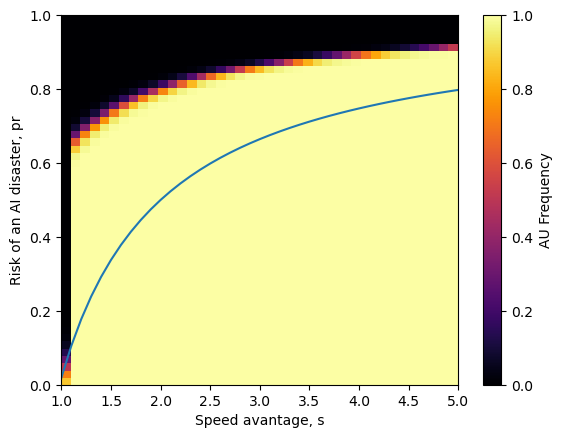

In [86]:
#| echo:false
table = df[(df.severity==1) & (df.phi_h_s==1)].pivot_table(index='pr', columns='s', values='AU_frequency')
plot_heatmap(table,
             xlabel='Speed avantage, s',
             ylabel='Risk of an AI disaster, pr',
             zlabel='AU Frequency',
             cmap='inferno',
            )

# Add threshold boundaries to convey dilemma region
plt.plot(table.columns, df[(df.pr==1) & (df.severity==1) & (df.phi_h_s ==1)]['threshold_society_prefers_safety'])
# plt.plot(table.columns, df[df.pr==1]['threshold_risk_dominant_safety']);

In [131]:
df['in_dilemma_zone'] = (df.pr >= df.threshold_society_prefers_safety)
df['phi_h_s'] = (df.phi_h * df.s).round(decimals=2)
df_dilemma = df[df.in_dilemma_zone==True]

In [132]:
df_no_dilemma = df[df.in_dilemma_zone==False]

In [142]:
pre_plot_data = df_dilemma.groupby(["severity", "phi_h_s"]).AS_frequency.mean().reset_index()

In [143]:
import plotly.express as px

In [144]:
plot_data = pre_plot_data[(pre_plot_data.phi_h_s < 1.01)
                          & ((pre_plot_data.severity > 0.6)
                             | (pre_plot_data.severity < 0.56))]
plot_data["AU_frequency"] = 1 - plot_data["AS_frequency"]

/tmp/ipykernel_49132/1831347656.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [145]:
fig = px.line(plot_data, x="severity", y="AU_frequency", color="phi_h_s", line_shape='spline')

fig.update_layout(xaxis_title='Threat threshold (omega)',
                   yaxis_title='Total Unsafe Behaviour (in the Dilemma Zone)',
                   legend_title='Unsafe penalty (phi)')

In [138]:
pre_plot_data = df_no_dilemma.groupby(["severity", "phi_h_s"]).AU_frequency.mean().reset_index()

In [139]:
plot_data = pre_plot_data[(pre_plot_data.phi_h_s < 1.01)
                          & ((pre_plot_data.severity > 0.6)
                             | (pre_plot_data.severity < 0.56))]

In [140]:
fig = px.line(plot_data, x="severity", y="AU_frequency", color="phi_h_s", line_shape='spline')

fig.update_layout(xaxis_title='Threat threshold (omega)',
                   yaxis_title='Total Risk-taking (in the Risk-taking Zone)',
                   legend_title='Unsafe penalty (phi)')